<a href="https://colab.research.google.com/github/KuldipGupta/Story/blob/main/SarcasmDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import json
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

data = []
with open("Sarcasm_Headlines_Dataset.json", "r") as file:
    for line in file:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Skipping invalid line: {line.strip()} due to error: {e}")

df = pd.DataFrame(data)

print(df.head())

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [6]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 24.0 MB/s eta 0:00:00


In [11]:
import re
import emoji

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r"[^a-zA-Z0-9#@' ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [22]:
df["text"] = df["headline"].apply(preprocess_text)

texts = df["text"].values
labels = df["is_sarcastic"].values


In [23]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 50
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [14]:
# BiLSTM
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),

    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),

    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])


model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

checkpoint = ModelCheckpoint("best_bilstm_model.h5", save_best_only=True, monitor="val_accuracy", mode="max")


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=32,
    callbacks=[checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7315 - loss: 0.5034

668/668 ━━━━━━━━━━━━━━━━━━━━ 192s 262ms/step - accuracy: 0.7316 - loss: 0.5033 - val_accuracy: 0.8680 - val_loss: 0.3136
Epoch 2/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 196s 254ms/step - accuracy: 0.9210 - loss: 0.2128 - val_accuracy: 0.8618 - val_loss: 0.3423
Epoch 3/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 202s 255ms/step - accuracy: 0.9544 - loss: 0.1249 - val_accuracy: 0.8553 - val_loss: 0.4019
Epoch 4/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 199s 250ms/step - accuracy: 0.9727 - loss: 0.0835 - val_accuracy: 0.8501 - val_loss: 0.5055
Epoch 5/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 203s 251ms/step - accuracy: 0.9811 - loss: 0.0567 - val_accuracy: 0.8443 - val_loss: 0.6138
Epoch 6/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 165s 248ms/step - accuracy: 0.9873 - loss: 0.0389 - val_accuracy: 0.8448 - val_loss: 0.7421
Epoch 7/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 209s 258ms/step - accuracy: 0.9918 - loss: 0.0274 - val_accuracy: 0.8456 - val_loss: 0.8619
Epoch 8/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 171s 257ms/step - accuracy: 0.9930 - loss: 0.02

In [45]:
best_model = load_model("best_bilstm_model.h5")

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

def predict_sarcasm(text):
    seq = tokenizer.texts_to_sequences([preprocess_text(text)])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
    pred = best_model.predict(padded)[0][0]
    return "Sarcasm" if pred > 0.5 else "Not Sarcasm"

print(predict_sarcasm("Oh wow, that’s EXACTLY what I wanted!"))



167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8698 - loss: 0.3122
Test Accuracy: 0.8680
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Not Sarcasm


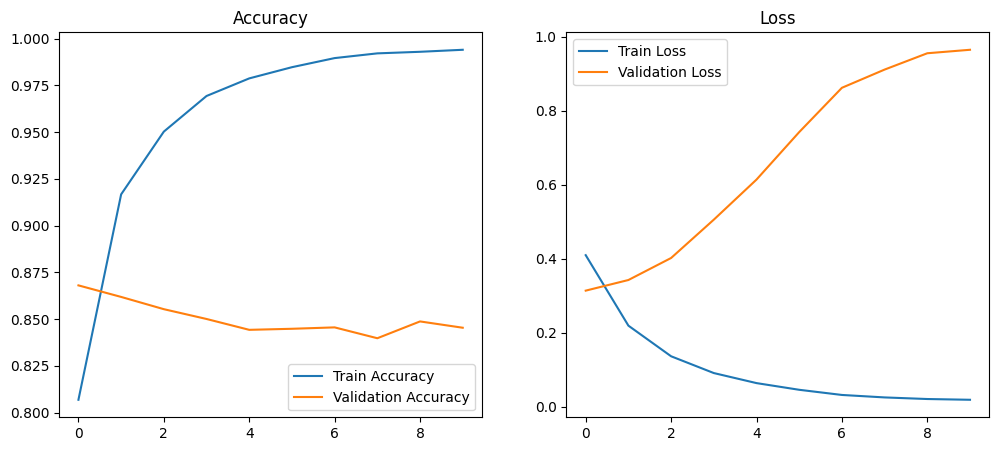

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()
